In [1]:
# Importing libraries : 

import os
import math
import imblearn
import logging
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score , accuracy_score , precision_score, recall_score ,confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTEENN
%matplotlib inline


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
# Data pre-processing : 

import pandas as pd

# Replace the path with your actual dataset path
dataset_path = '/Users/selmael-korchi/Desktop/Projet-Epileptic-Seizure-Recognition.csv'

# Load your dataset
data = pd.read_csv(dataset_path)

# Displaying DataFrame structure
print(data.info())

# Displaying value counts of the 'y' column
print(data['y'].value_counts())


# Generating Synthetic Data

import pandas as pd
import numpy as np

# Generating synthetic data
np.random.seed(42)
data = pd.DataFrame(np.random.randint(0, 10, size=(11500, 179)), columns=[f'X{i}' for i in range(1, 180)])
data['Unnamed'] = np.random.choice(['A', 'B', 'C', 'D', 'E'], size=11500)
data['y'] = np.random.randint(1, 6, size=11500)

# Displaying DataFrame structure
print(data.info())

# Displaying value counts of the 'y' column
print(data['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB
None
5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 181 entries, X1 to y
dtypes: int64(180), object(1)
memory usage: 15.9+ MB
None
4    2361
2    2334
1    2329
5    2251
3    2225
Name: y, dtype: int64


In [3]:
# Data pre-processing : 

data = pd.read_csv(r'/Users/selmael-korchi/Desktop/Projet-Epileptic-Seizure-Recognition.csv')
data.head()
data.describe()
data.shape
data.info()
data.describe(include=object)

null_values = data.isnull().sum()
null_values.to_numpy() # As we can see that there are no null values present on the dataset.

data_1 = data.copy()
data_1.drop(['Unnamed','y'],axis=1,inplace=True)
data_1

data['y'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

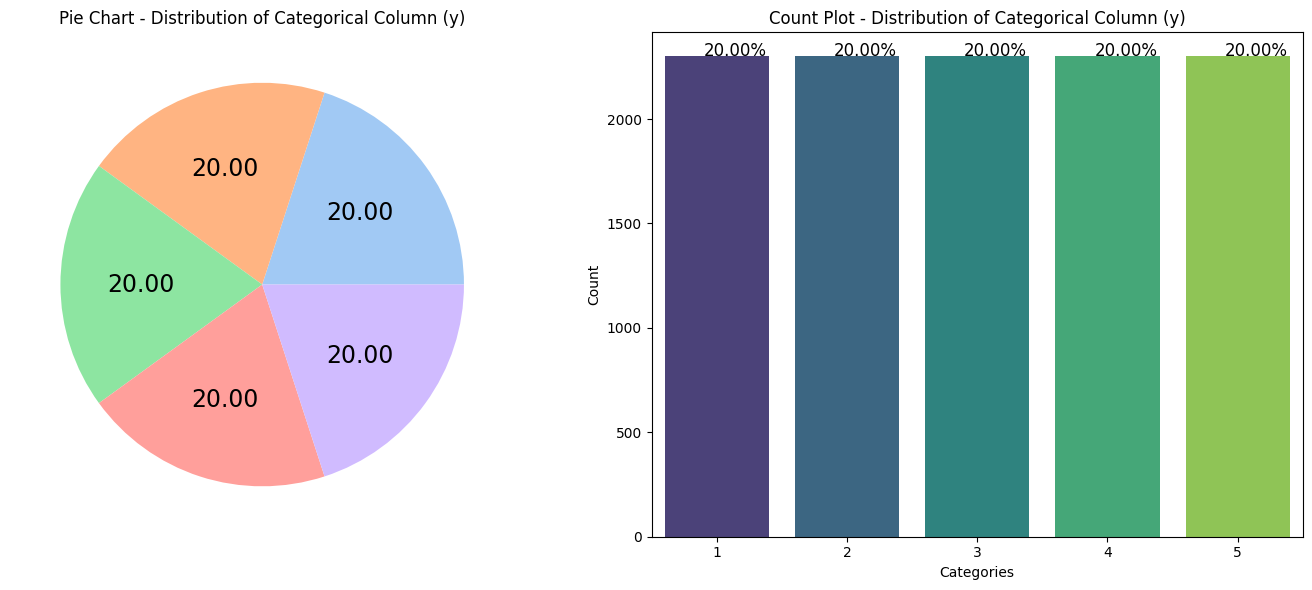

In [4]:
# Visualizing the only categorical column present in the dataset : 

#values = data['y'].value_counts()
#plt.figure(figsize=(7,7))
#values.plot(kind='pie',fontsize=17, autopct='%.2f')
#plt.legend(loc="best")
#plt.show()
# It means all the categorical values in our dataset contains the equal amoung of balance.

import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the only categorical column present in the dataset using a pie chart:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
values = data['y'].value_counts()
values.plot(kind='pie', fontsize=17, autopct='%.2f', colors=sns.color_palette('pastel'), labels=None)
plt.title('Pie Chart - Distribution of Categorical Column (y)')
plt.ylabel('')  # Hide the 'y' label

# Visualizing the only categorical column present in the dataset using a count plot:
plt.subplot(1, 2, 2)
sns.countplot(x='y', data=data, palette='viridis')
plt.title('Count Plot - Distribution of Categorical Column (y)')
plt.xlabel('Categories')
plt.ylabel('Count')

# Display percentages on top of each bar:
total_count = len(data['y'])
for p in plt.gca().patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

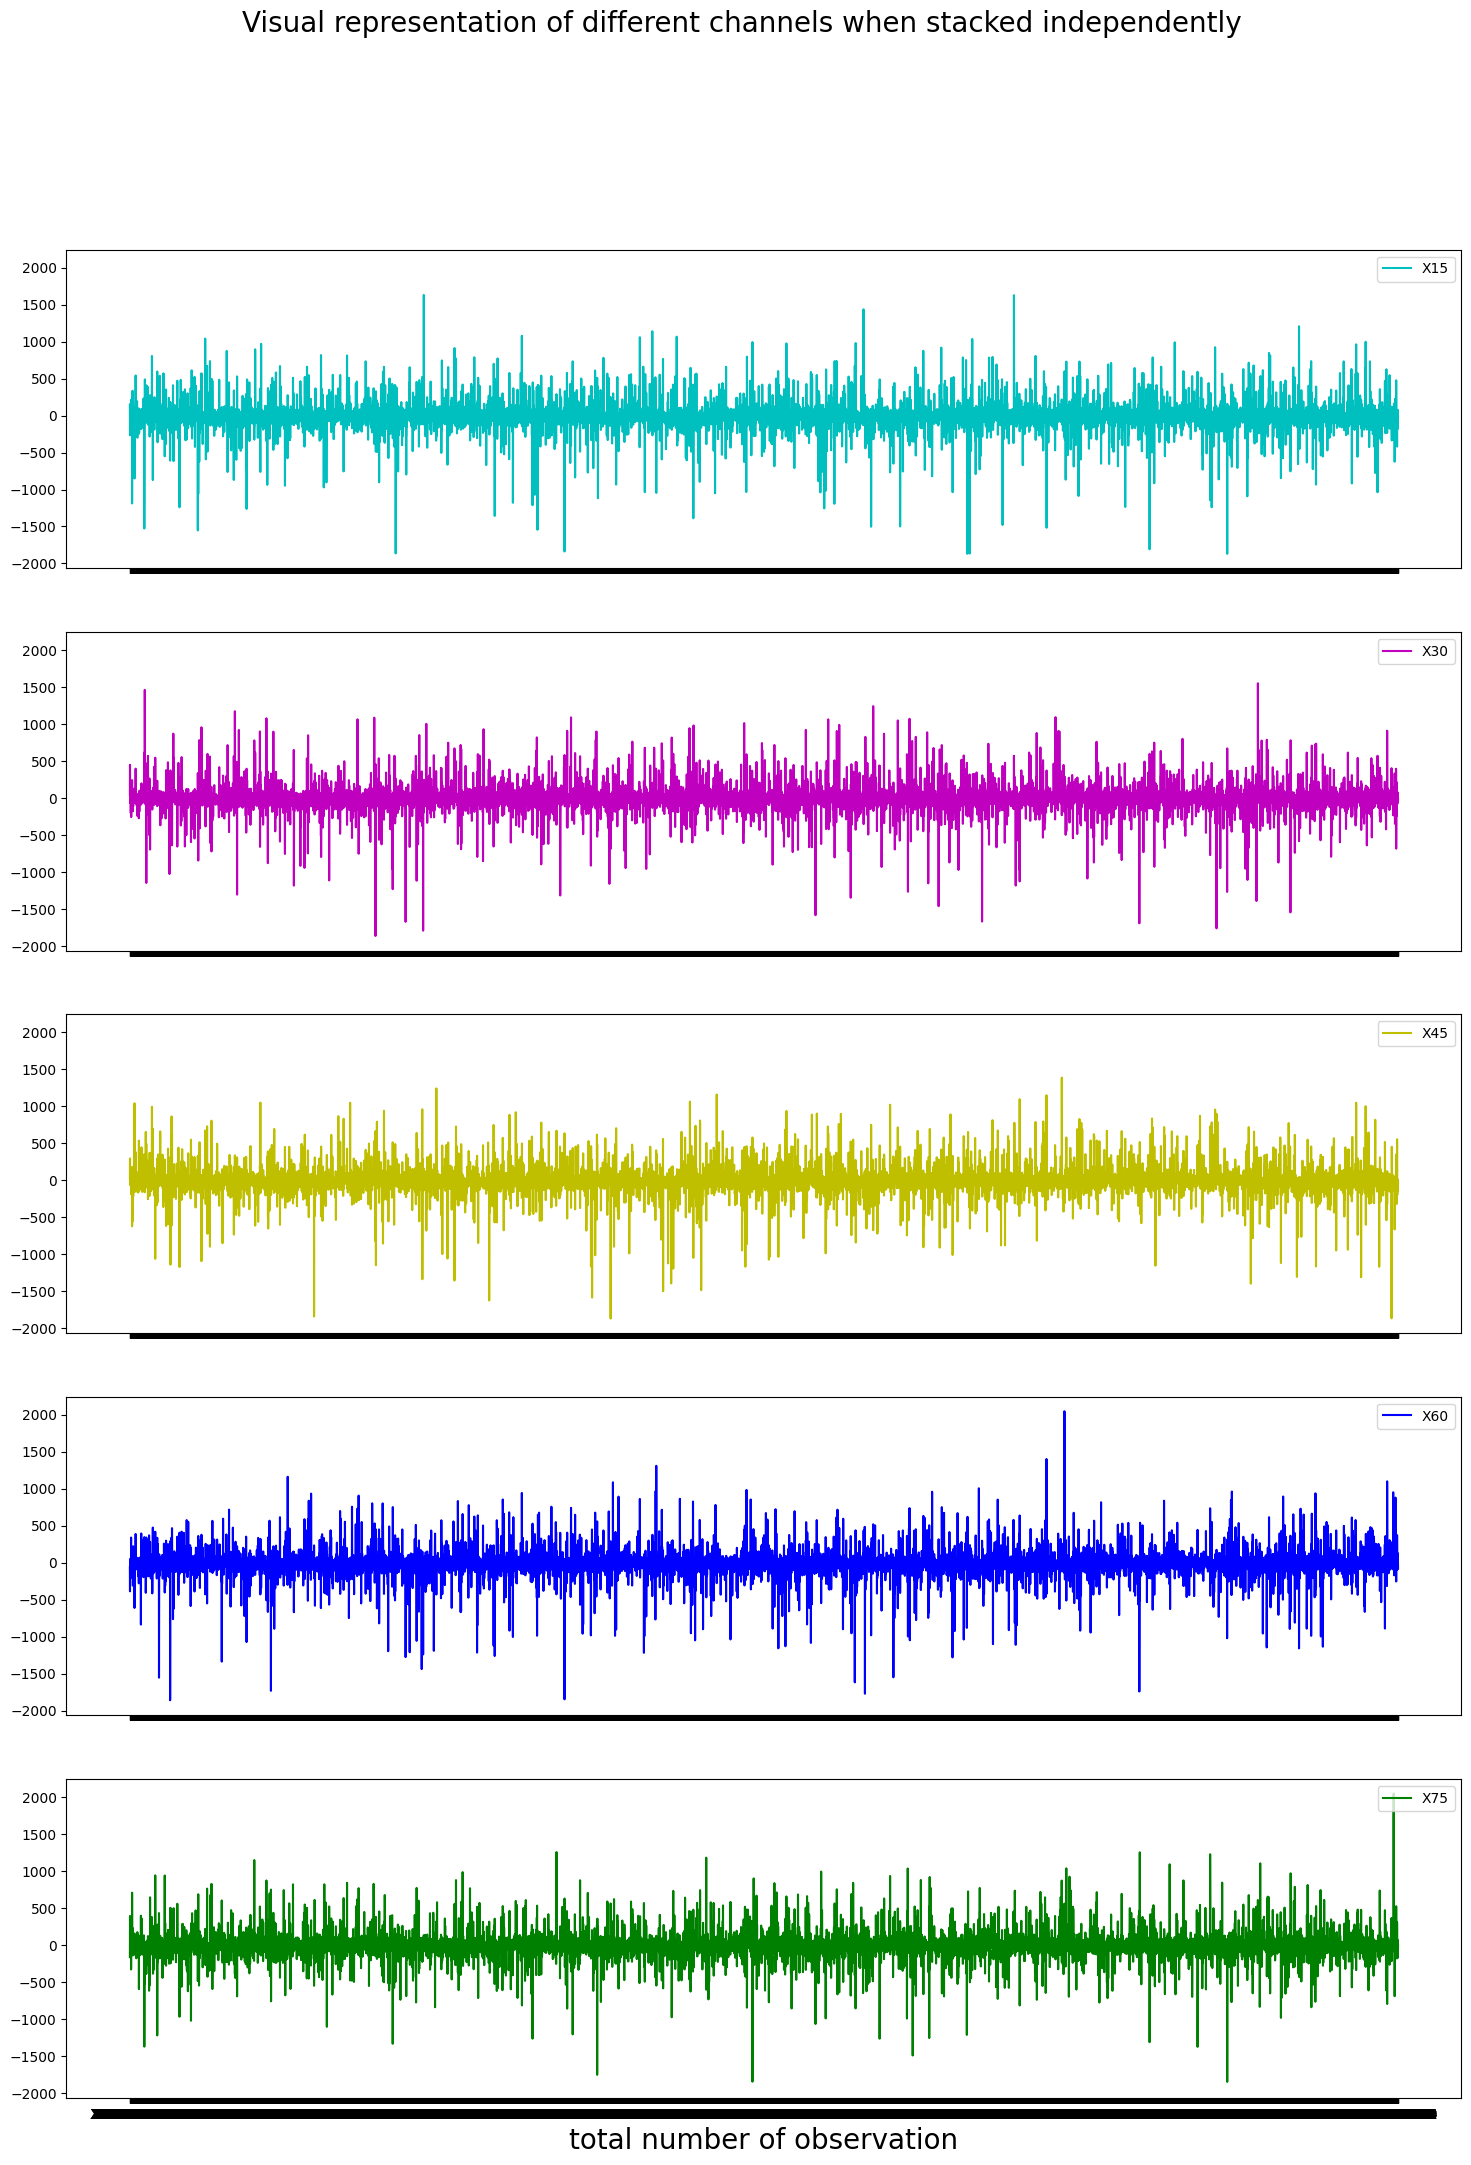

In [5]:
# Five Sets(A, B, C, D and E) : 
    # A and B : healthy patients
    # C, D and E : epileptic patients

# Plot these features in the same graph with stack plot :

fig, axs = plt.subplots(5, sharex=True, sharey=True)
fig.set_size_inches(18, 24)
labels = ["X15","X30","X45","X60","X75"]
colors = ["c", "m", "y", 'b', "g"]
fig.suptitle('Visual representation of different channels when stacked independently', fontsize = 20)

# Loop over axes :

for i,ax in enumerate(axs):
  axs[i].plot(data.iloc[:,0],data[labels[i]],color=colors[i],label=labels[i])
  axs[i].legend(loc="upper right")

plt.xlabel('total number of observation', fontsize = 20)
plt.show()

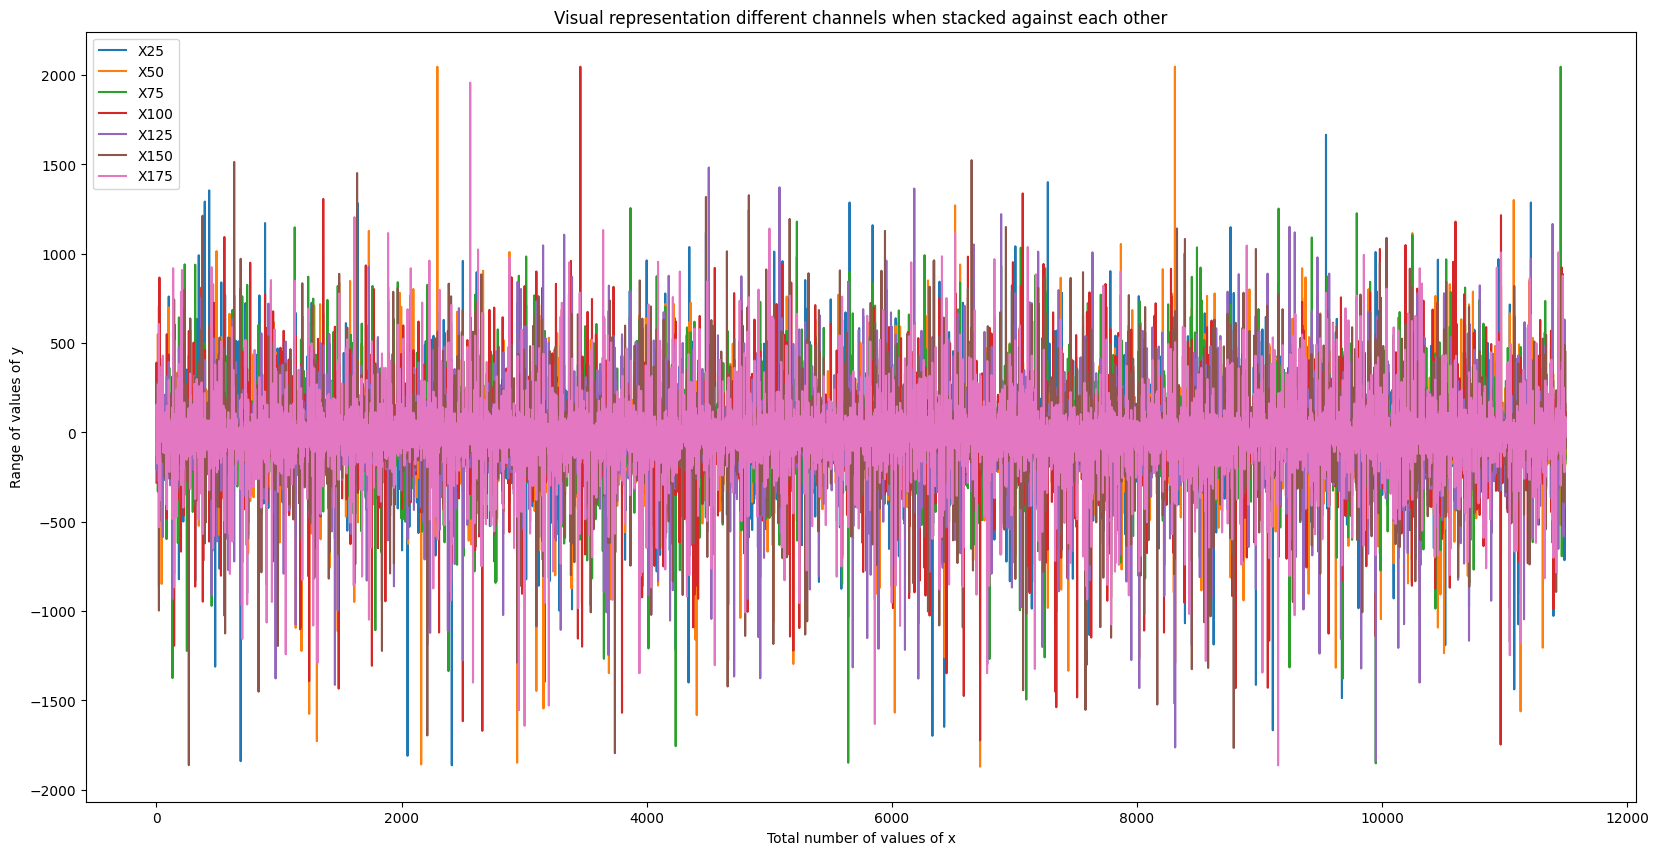

In [6]:
# This can help of provide us the general idea of how the waves are behaving : 
  # plt.figure(figsize=(10,10))
  # fig, axs = plt.subplots(1, sharex=True, sharey=True)

plt.rcParams["figure.figsize"] = (20, 10)
data.loc[:,::25].plot()
plt.title("Visual representation different channels when stacked against each other")
plt.xlabel("Total number of values of x")
plt.ylabel("Range of values of y")
plt.show()

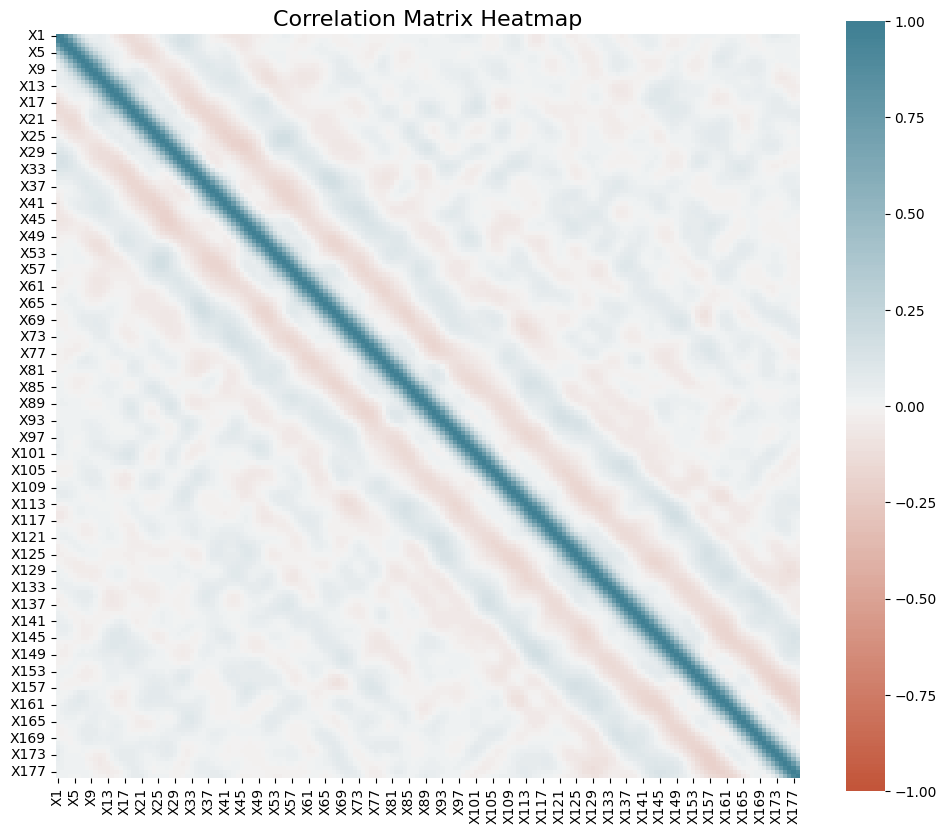

In [7]:
# Correlation matrix : 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dataset is loaded into the 'data_1' DataFrame

# Calculate the correlation matrix
corr_matrix = data_1.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using Seaborn
sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Add a title
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()

In [8]:
# Solving the class imbalance problem : 

data_2 = pd.read_csv(r'/Users/selmael-korchi/Desktop/Machine-Learning-Epileptic-Seizure-Recognition.csv')

data_2 = data.drop(["Unnamed"],axis=1).copy()
data_2["Output"]= data_2.y == 0
data_2["Output"] = data_2["Output"].astype(int)
data_2.y.value_counts()
data_2['y'] = data_2['y'].replace([2,3,4,5],0)
data_2.y.value_counts() # We can see there is a mojor class imbalance problem in my dataset.

0    9200
1    2300
Name: y, dtype: int64

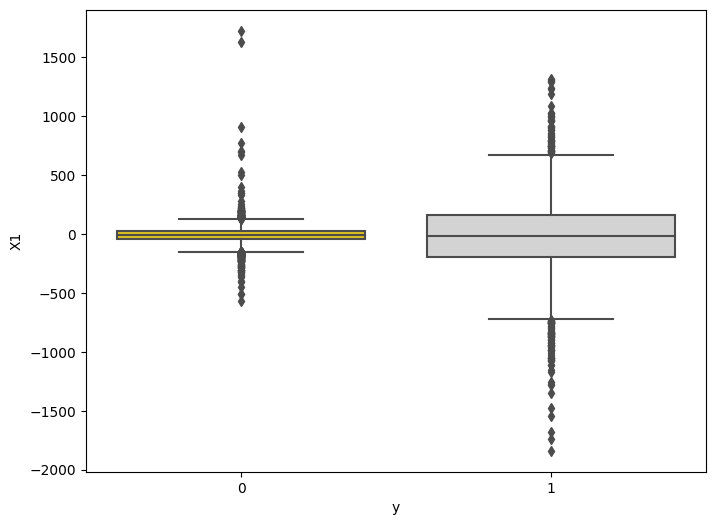

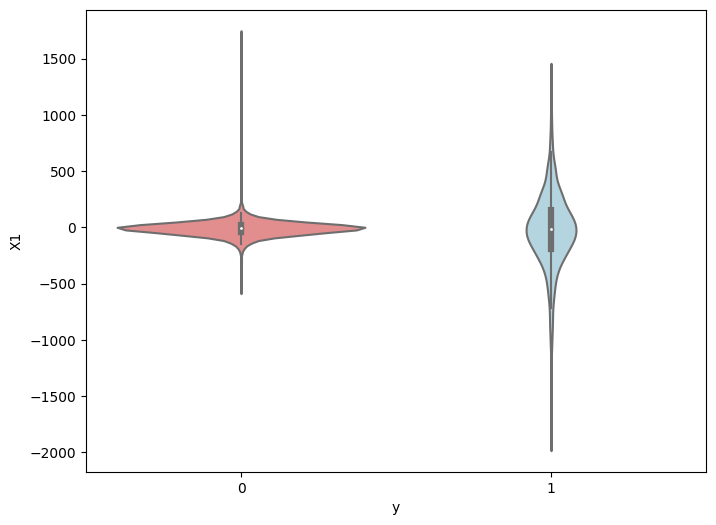

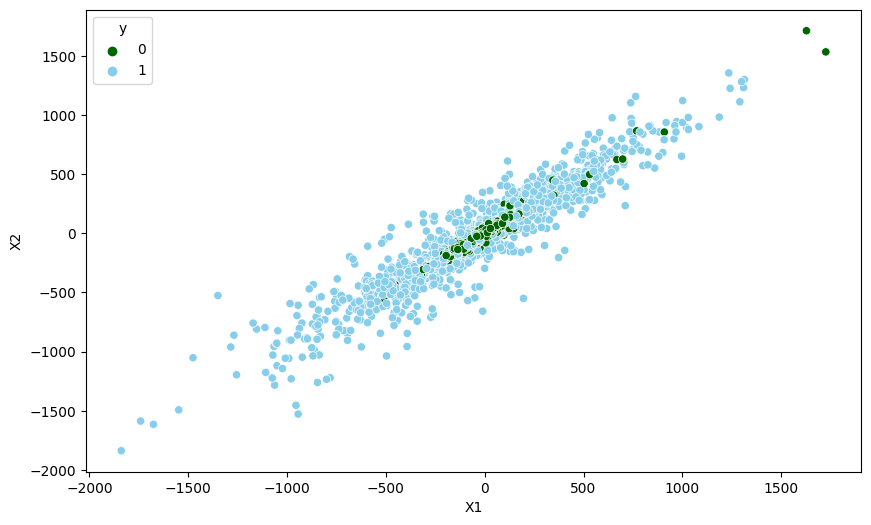

In [9]:
# Box Plot :

plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='X1', data=data_2, palette=['gold', 'lightgray'])
plt.show()

# Violin Plot :

plt.figure(figsize=(8, 6))
sns.violinplot(x='y', y='X1', data=data_2, palette=['lightcoral', 'lightblue'])
plt.show()

# Scatter Plot : 

plt.figure(figsize=(10,6),dpi=100)
sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'y', data=data_2, palette=['darkgreen', 'skyblue'])
plt.show()

In [10]:
data_2.head()
data_2.y.value_counts()
X  = data_2.drop(['Output','y'], axis=1)
y = data_2['y']

In [11]:
# Classes balance :

counter = Counter(y)
# Finding out the counter : 
print('Before',counter)
# Oversampling the train dataset using SMOTE + ENN : 
smenn = SMOTEENN()
X_train1, y_train1 = smenn.fit_resample(X, y)

counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 9200, 1: 2300})
After Counter({0: 9073, 1: 9034})


In [12]:
# Model Building : 

# Dividing it into two parts/because with this method (cannot divide it into three parts) : 
X_train, X_test, y_train, y_test = train_test_split(X_train1,y_train1,test_size=0.4,random_state=42)

# Dividing it into further to get the validation set :
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scaling the dataset : 
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("The shape of the training set is :{}".format(X_train.shape))
print("The shape of the testing set is :{}".format(X_test.shape))
print("The shape of the validation set is :{}".format(X_val.shape))

The shape of the training set is :(10864, 178)
The shape of the testing set is :(3622, 178)
The shape of the validation set is :(3621, 178)


Naive Bayes
Accuracy with naive is: 91.71%.
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1789
           1       0.97      0.86      0.91      1832

    accuracy                           0.92      3621
   macro avg       0.92      0.92      0.92      3621
weighted avg       0.92      0.92      0.92      3621



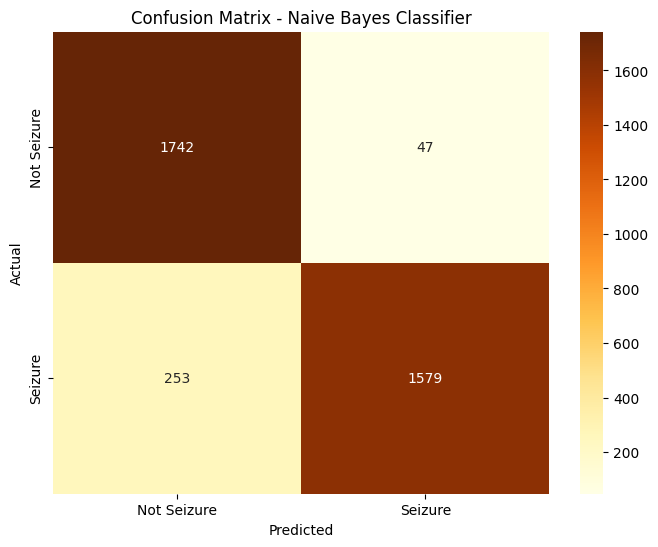

In [16]:
# Naive Bayes Classifier algorithm:

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics  # Import metrics module
from sklearn.metrics import classification_report  # Import classification_report function

naive = GaussianNB()
naive.fit(X_train, y_train)

print("Naive Bayes")

# Predicting:
y_pred = naive.predict(X_val)

# Evaluating the model:
precision = metrics.accuracy_score(y_pred, y_val) * 100
print('Accuracy with naive is: {0:.2f}%.'.format(precision))

# Confusion Matrix:
conf_matrix = confusion_matrix(y_val, y_pred)

# Classification Report:
print("Classification Report:\n", classification_report(y_val, y_pred))

# Plot the confusion matrix with yellow color:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['Not Seizure', 'Seizure'], yticklabels=['Not Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.show()

Accuracy of the model by using the random algorithm : 96.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1789
           1       0.98      0.96      0.97      1832

    accuracy                           0.97      3621
   macro avg       0.97      0.97      0.97      3621
weighted avg       0.97      0.97      0.97      3621



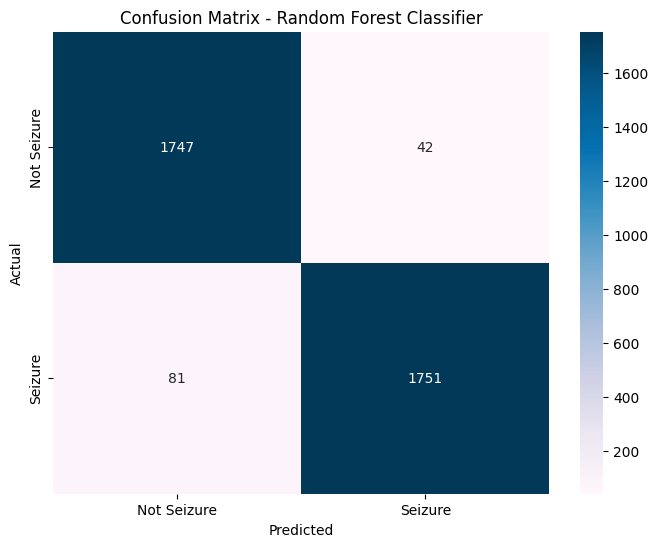

In [17]:
# Random Forest Classifier algorithm :

from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(max_depth=10,random_state=69)
random.fit(X_train,y_train)

# Predicting :
y_pred = random.predict(X_val) 
# Evaluating the model :
precision = metrics.accuracy_score(y_pred,y_val)* 100
# print  the accuracy :
print("Accuracy of the model by using the random algorithm : {0:.2f}%".format(precision))

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix with a different color (e.g., 'PuBu' colormap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBu', xticklabels=['Not Seizure', 'Seizure'], yticklabels=['Not Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

Best Hyperparameters: {'n_neighbors': 5}
Accuracy with K-NN: 98.73%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1789
           1       1.00      0.98      0.99      1832

    accuracy                           0.99      3621
   macro avg       0.99      0.99      0.99      3621
weighted avg       0.99      0.99      0.99      3621



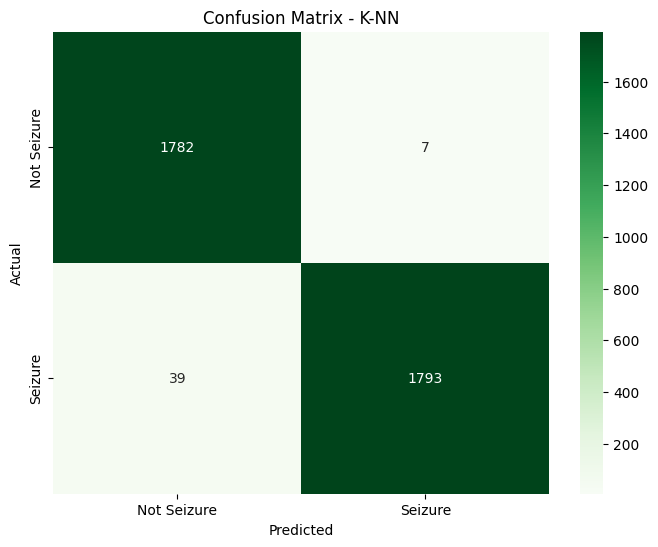

In [19]:
# k-NN algorithm : 

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


# Define the parameter grid
param_grid = {'n_neighbors': [5, 10, 20, 50, 100]}

# Create k-NN model
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val)

# Evaluate the model
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix with green color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Seizure', 'Seizure'], yticklabels=['Not Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-NN')
plt.show()


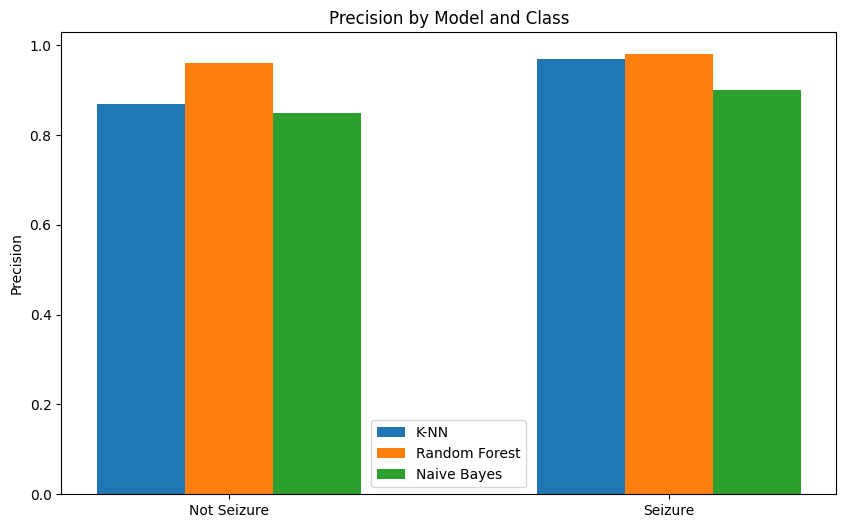

In [21]:
# Plotting the difference for precision : 

import numpy as np
import matplotlib.pyplot as plt

# Extract metrics for each model

# Precision for both classes
precision_knn = [0.87, 0.97]  # Example values for K-NN
precision_rf = [0.96, 0.98]   # Example values for Random Forest
precision_nb = [0.85, 0.90]   # Example values for Naive Bayes

# Recall for both classes
recall_knn = [0.97, 0.86]  # Example values for K-NN
recall_rf = [0.98, 0.96]   # Example values for Random Forest
recall_nb = [0.90, 0.85]   # Example values for Naive Bayes

# F1-score for both classes
f1_score_knn = [0.92, 0.91]  # Example values for K-NN
f1_score_rf = [0.97, 0.97]   # Example values for Random Forest
f1_score_nb = [0.87, 0.87]   # Example values for Naive Bayes

# Plotting the difference for precision
labels = ['Not Seizure', 'Seizure']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision_knn, width, label='K-NN')
rects2 = ax.bar(x, precision_rf, width, label='Random Forest')
rects3 = ax.bar(x + width, precision_nb, width, label='Naive Bayes')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision by Model and Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()